# Advanced Lane Lines

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.misc import imresize
import cv2

print("All module loaded")

Using TensorFlow backend.


All module loaded


## Calibrating

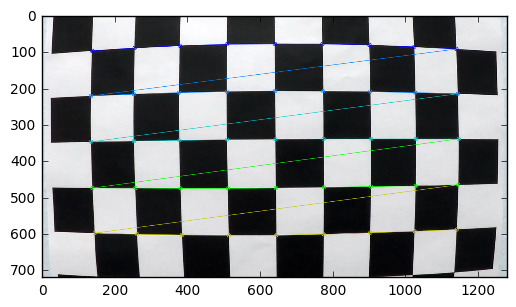

In [3]:

# Construct arrays for center, right and left images of controlled driving
images = np.asarray(os.listdir("camera_cal/"))

chess_data= []

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

count = 0
for image in images:
    image_file = os.path.join('camera_cal/', image)
    image_data = cv2.imread(image_file)
    gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
    # If found, add object points, image points (after refining them)
    chess_data.append(image_data)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image_data, (9,5), corners2, ret)
#         print(""true"")
#         plt.imshow(image_data)

        
#     #     chess_data[count] = image_data
#     break
%matplotlib inline
plt.imshow(chess_data[0])


# plt.imshow(image_data[0])

# print(len(image_data))

## Distortion Correction

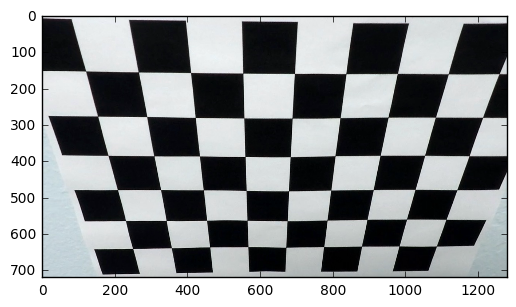

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist = cv2.undistort(chess_data[11], mtx, dist, None, mtx)
%matplotlib inline
plt.imshow(undist)

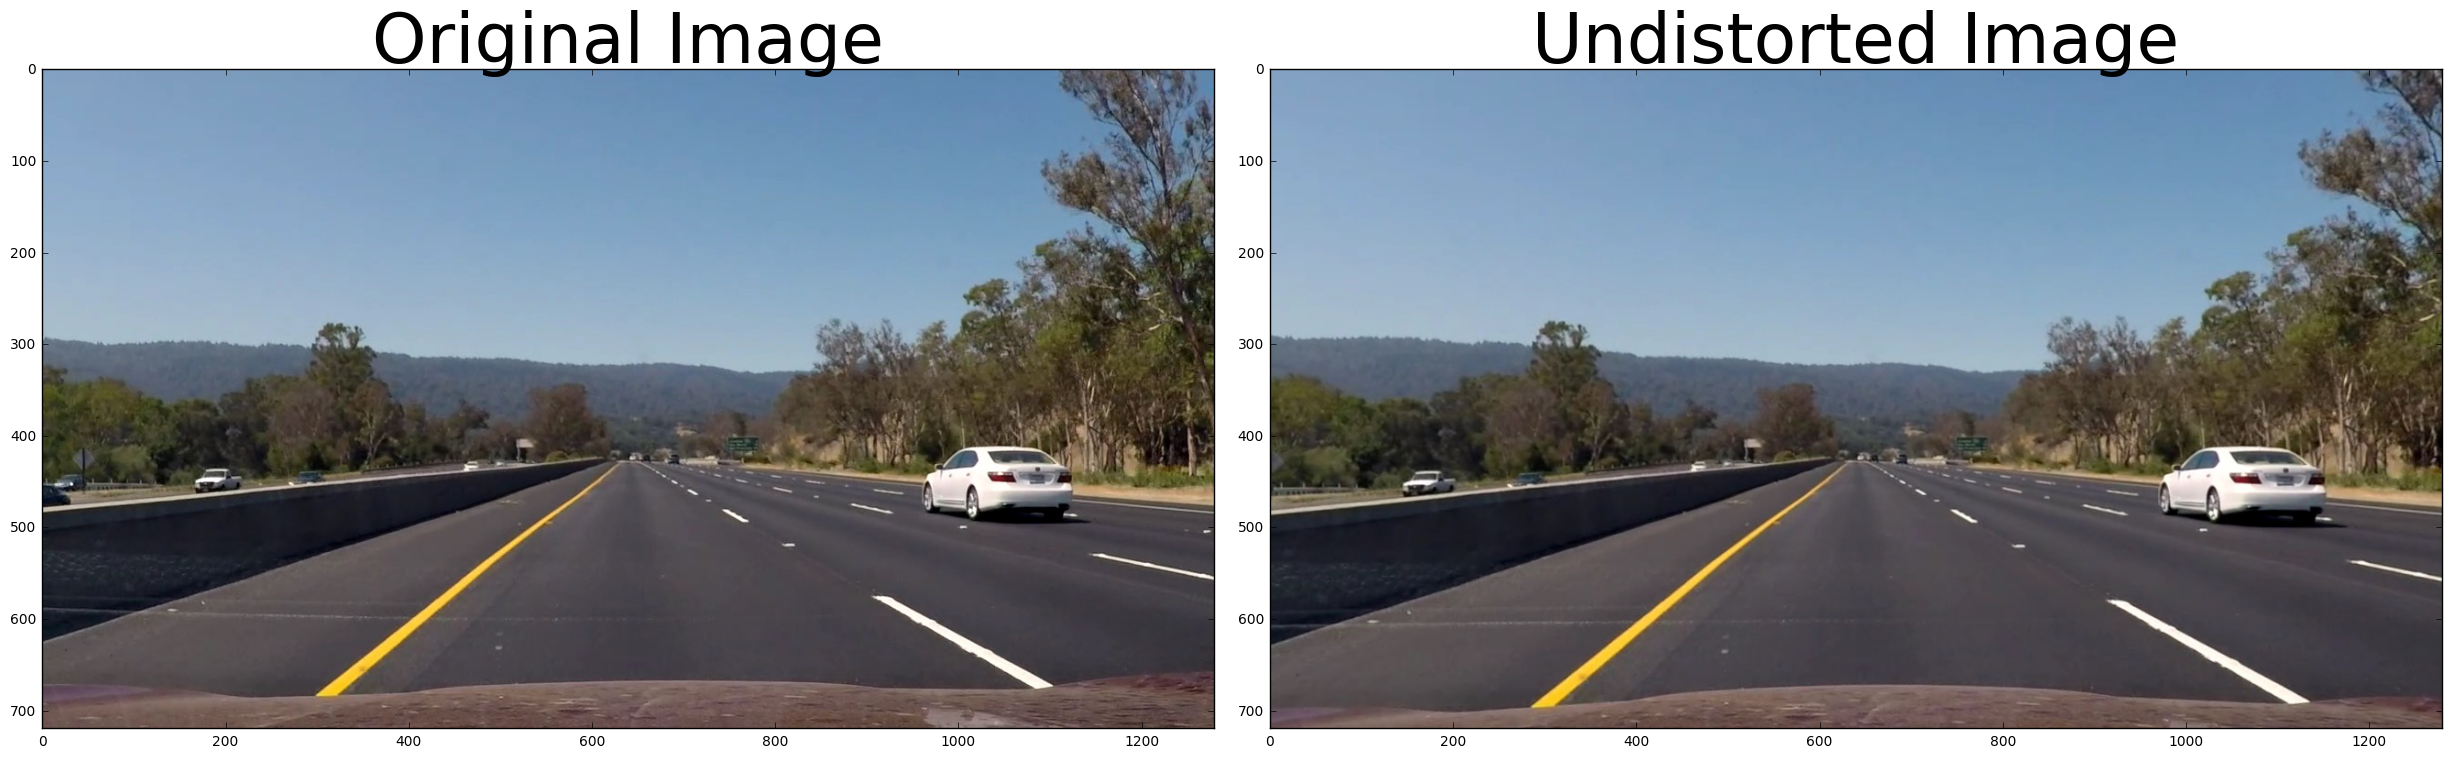

In [344]:
imageTest = mpimg.imread('perspective_straight.jpg')
undistTest = cv2.undistort(imageTest, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistTest)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

now we've got the undistorted image, the next step is to use sobel threshould and color space to extract lane lines.

## Threshold

In [345]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3,thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img,thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
#     retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return s_binary
    

In [346]:
def get_threshold_image(img):
    undistTest = cv2.undistort(img, mtx, dist, None, mtx)
    ksize = 5

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistTest, orient='x', sobel_kernel=3, thresh=(50, 100))
    grady = abs_sobel_thresh(undistTest, orient='y', sobel_kernel=3, thresh=(50, 100))
    mag_binary = mag_thresh(undistTest, sobel_kernel=5, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undistTest, sobel_kernel=7, thresh=(0.7, 1.3))


    color_binary = color_threshold(undistTest,thresh=(160,255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1

    return combined

The **get_threshold_image** is used for get combined result of gradient+color space. 

I used the (50,100) threshould for sobel operator at x and y directions, and (30,100) threshould for the magnitute of the sobel. (160,255) is choosed for the threshoud of the HLS color space.

The code bellow shows the result.

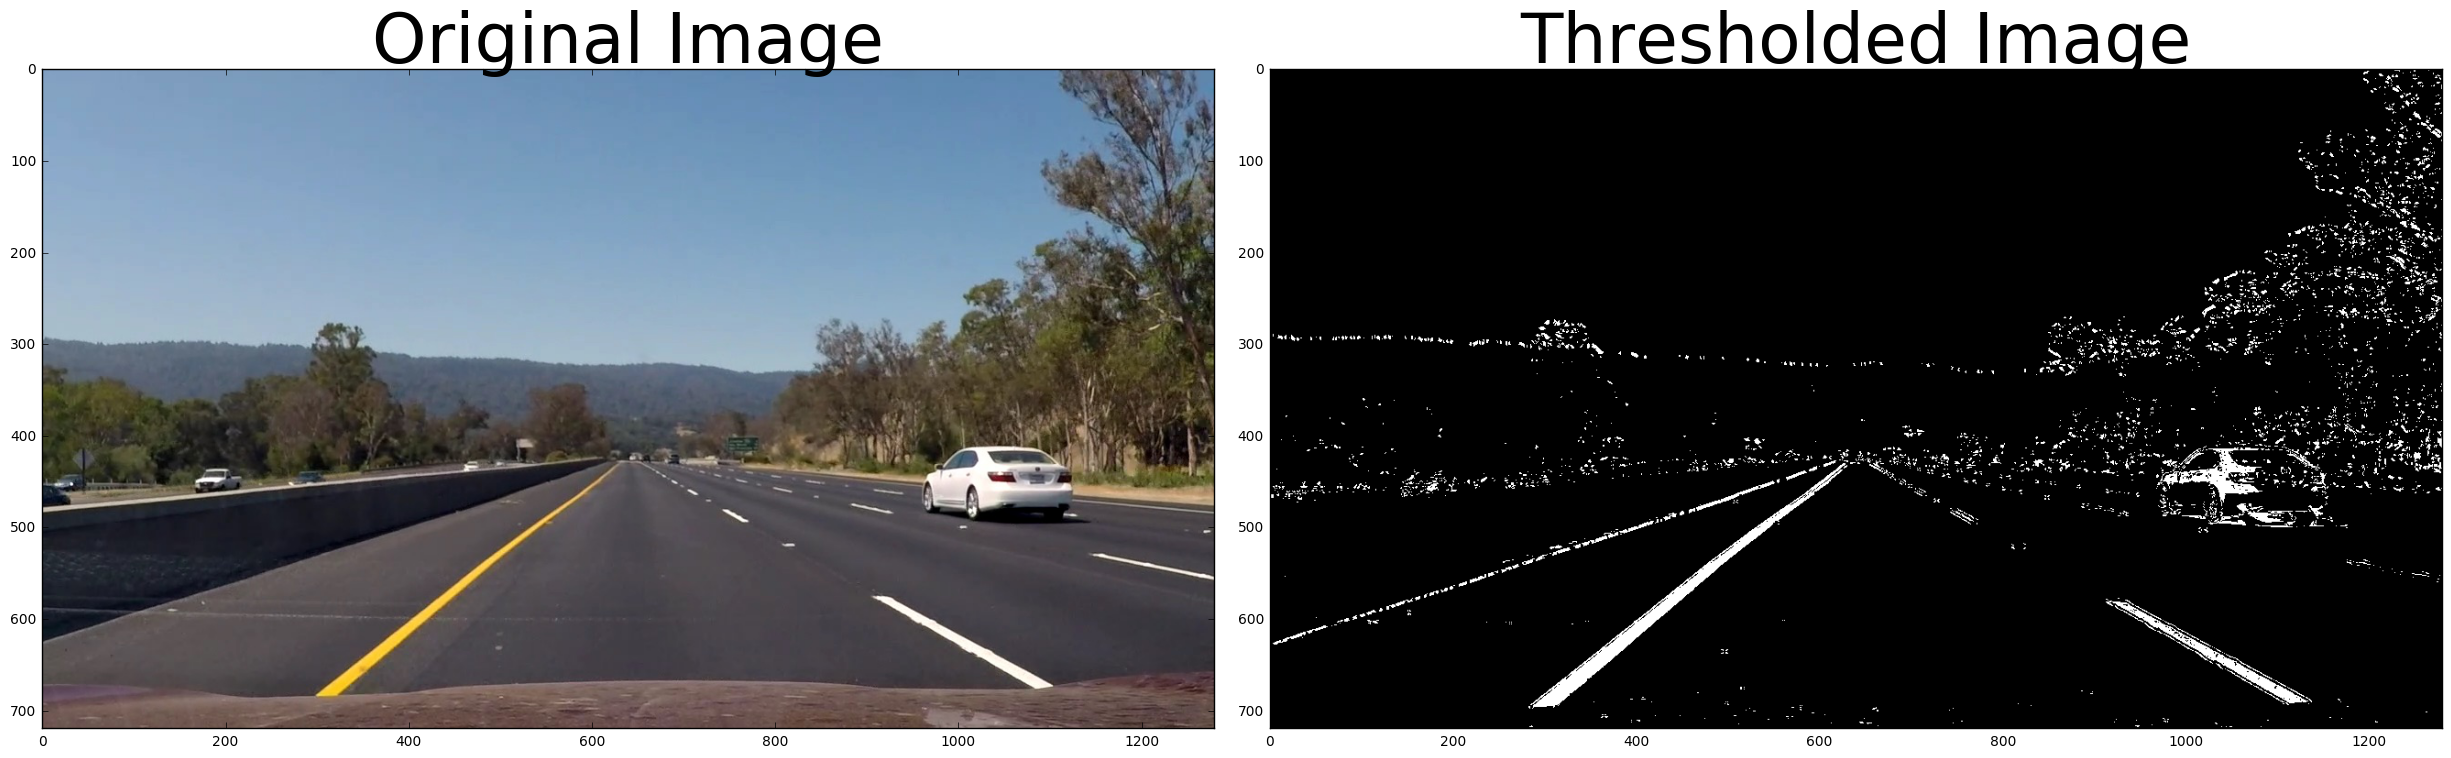

In [347]:
imageTest = mpimg.imread('perspective_straight.jpg')
# imageTest = mpimg.imread('test_images/test2.jpg')
combined = get_threshold_image(imageTest)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined,cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective Transform

I used the straight line image for testing, then choose the area for perspective transform approximitely. The result shows two lines parallely to each other approximitely, just as we expected.

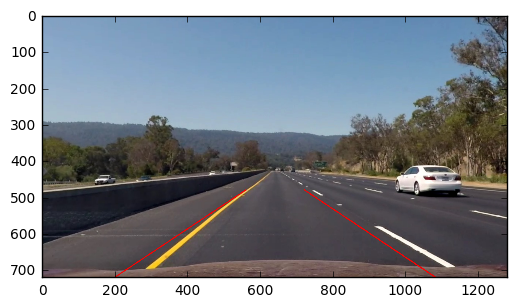

In [348]:
cv2.line(undistTest, (200, 720), (560, 480), [255,0,0], 2)
cv2.line(undistTest, (1080, 720), (720, 480), [255,0,0], 2)           
plt.imshow(undistTest)

In [349]:
def get_m_transform():
    src = np.float32([[560, 480], [720, 480],[1080, 720],[200, 720]])
    dst = np.float32([[300, 50], [980, 50],[980, 720],[300, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return (M,Minv)

In [350]:
def undistort_img(img):
    M = get_m_transform()[0]

    img_size = (img.shape[1], img.shape[0])
    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


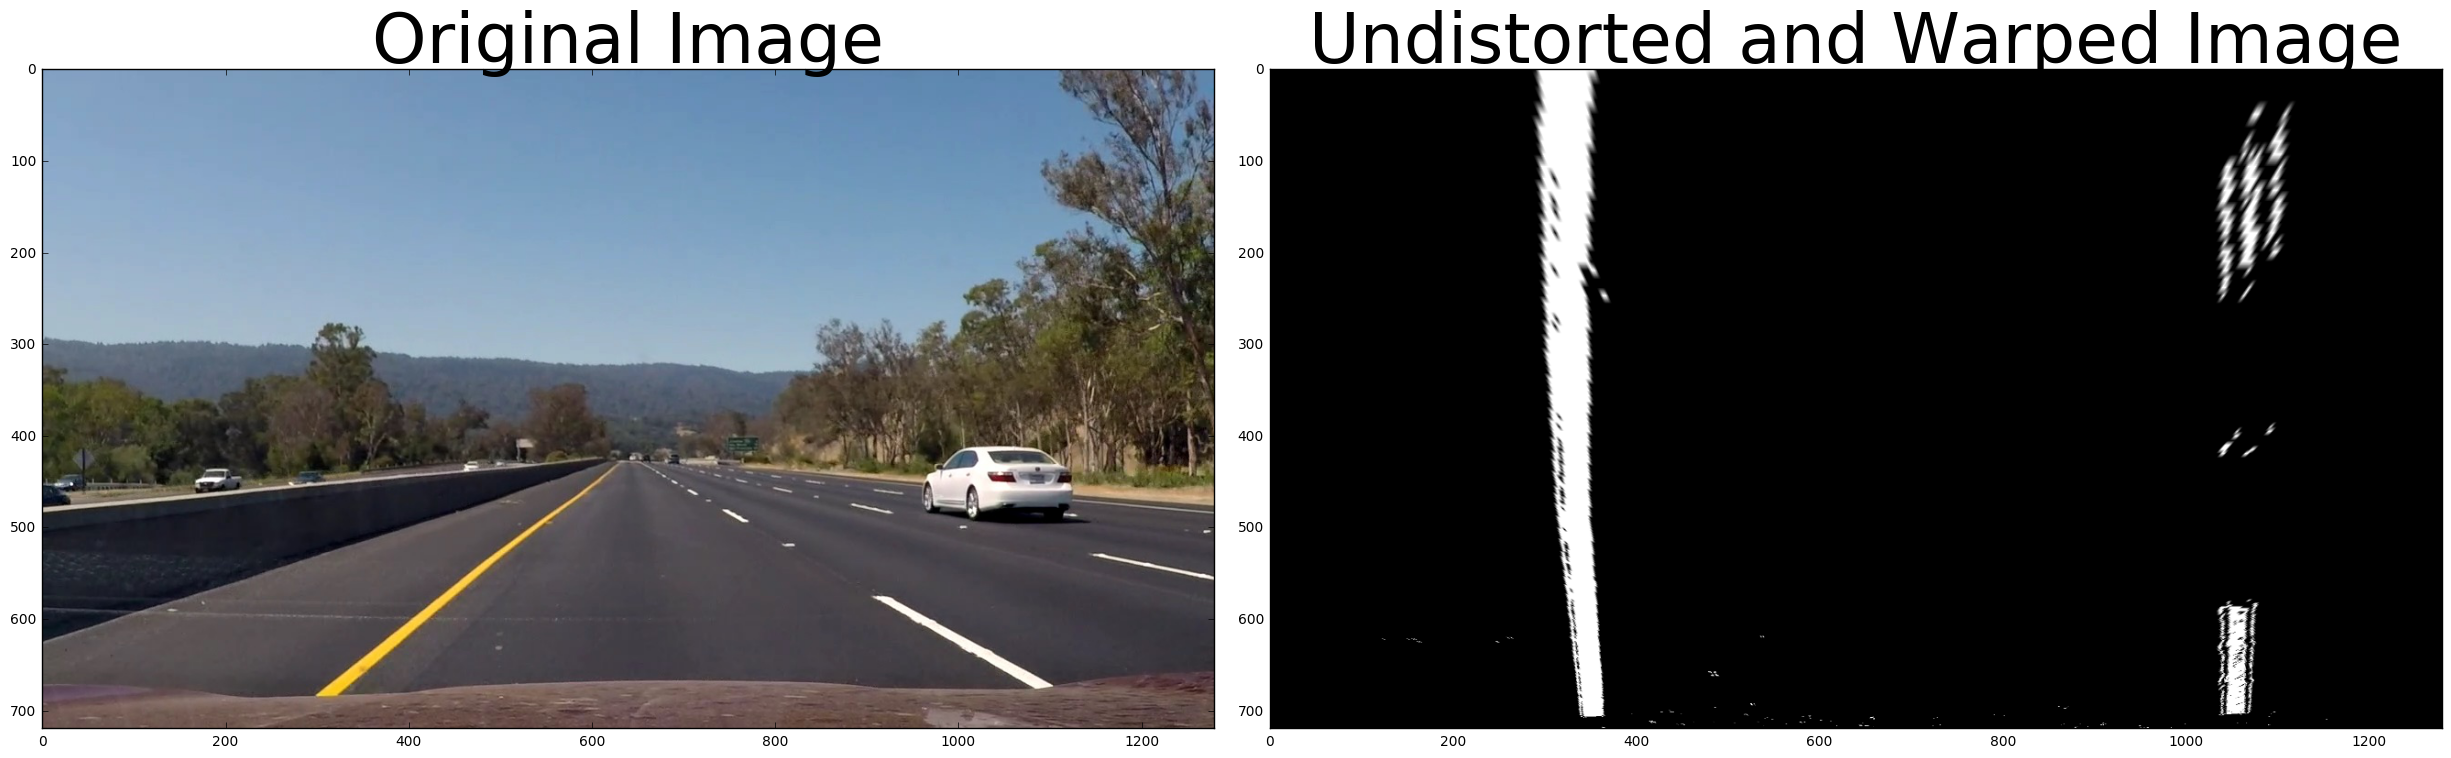

In [351]:
warped = undistort_img(combined)
       
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Filter lane-line pixels
The code bellow is from the sample code from the Udacity lecture

In [317]:
window_width = 100 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

The **get_filtered_points** will give the filtered result of the lane pixals, which is for the polynomial fitting

In [318]:
def get_filtered_points(img, window_width, window_height, margin):
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)
        l_points_filted = np.zeros_like(img)
        r_points_filted = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 

            l_points_filted[(img > 0) & ((l_mask == 1) ) ] = 255
            r_points_filted[(img > 0) & ((r_mask == 1) ) ] = 255

            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
    return (l_points_filted,r_points_filted,l_points,r_points)

The code bellow shows the result of result filtered by window template

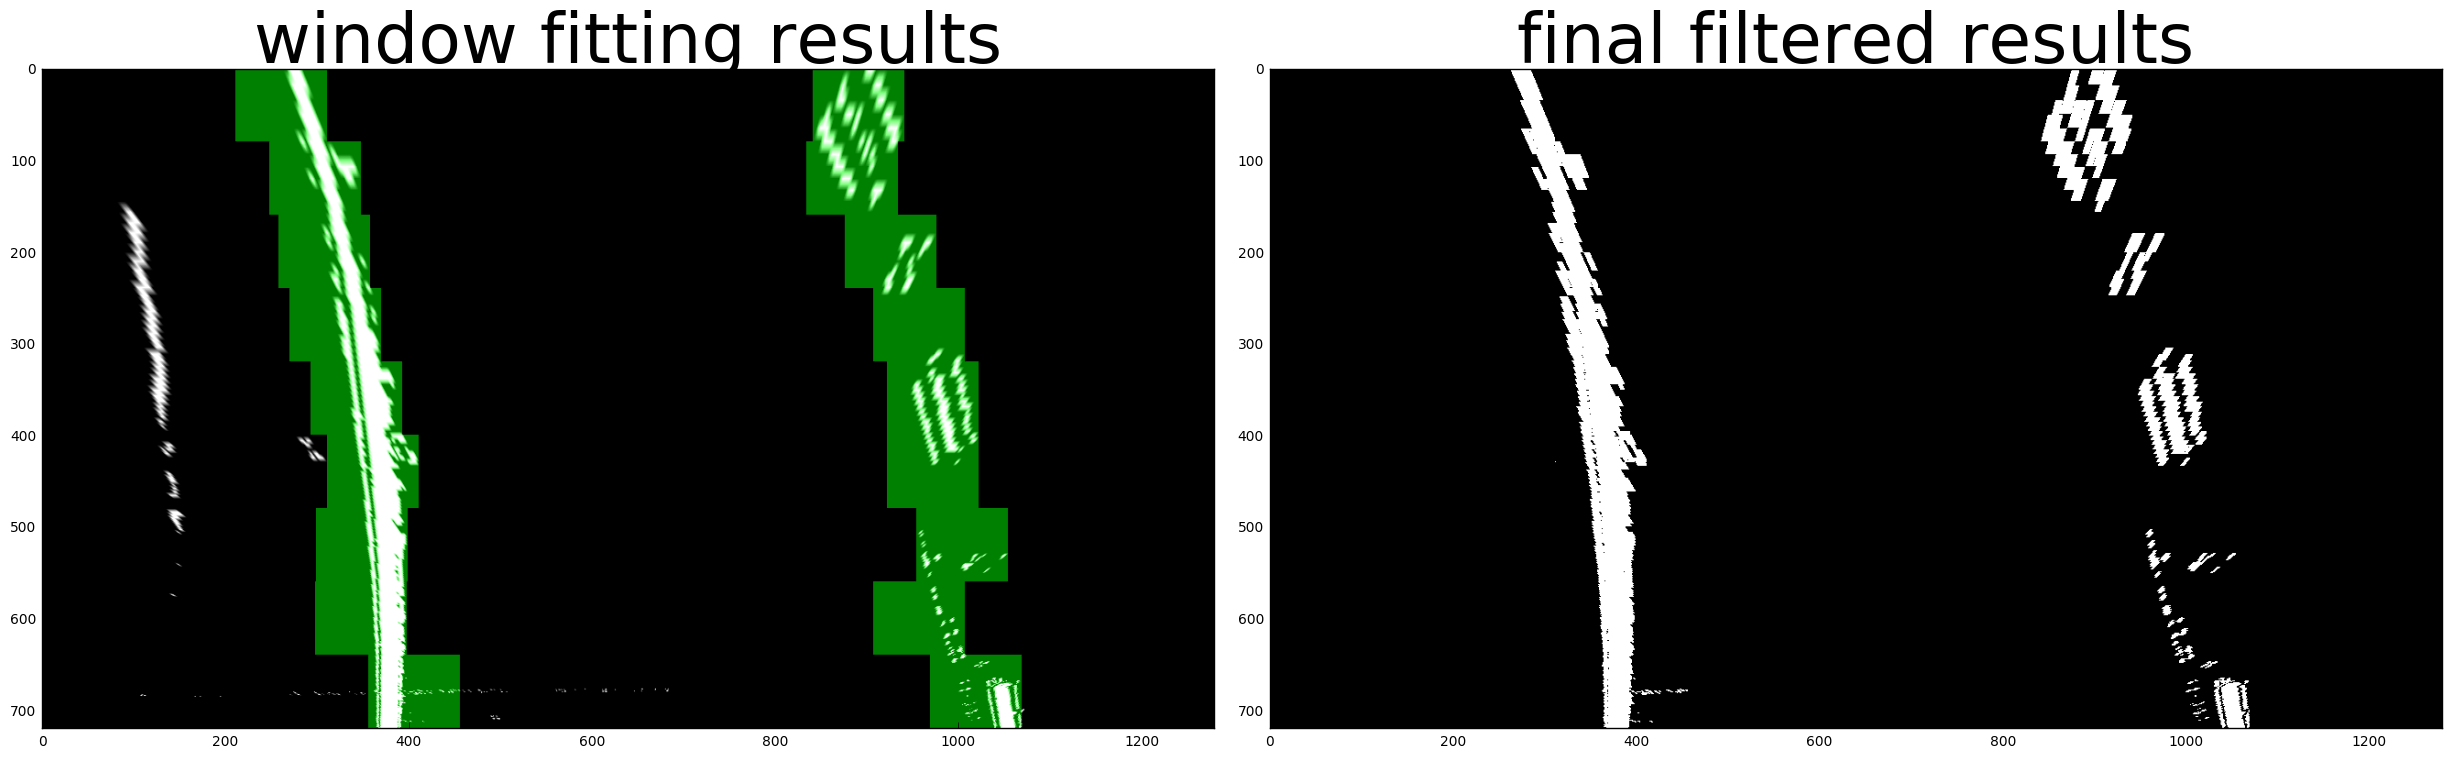

In [319]:
filtered_points = get_filtered_points(warped, window_width, window_height, margin)
l_points = filtered_points[:][0]
r_points = filtered_points[:][1]

t_l_points = filtered_points[:][2]
t_r_points = filtered_points[:][3]

result = np.array(r_points+l_points,np.uint8)
template = np.array(t_r_points+t_l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channle 
warpp = np.array(warped*255,np.uint8)
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((warpp,warpp,warpp)),np.uint8) # making the original road pixels 3 color channels
output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(output)
ax1.set_title('window fitting results', fontsize=50)
ax2.imshow(result,cmap='gray')
ax2.set_title('final filtered results', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Polynomial fitness

After generate the lane-line pixals, I used the polynomial fit function to get the polynomial parameter of lane-lines

In [320]:
def fit_as_polynome(points):
    curve_points_l_row = []
    curve_points_l_column = []
    curve_points_r_row = []
    curve_points_r_column = []
    for x in range(0,720):
        for y in range(0,1280):
            if points[0][x][y] > 0:
                curve_points_l_row.append(x)
                curve_points_l_column.append(y)
            if points[1][x][y] > 0:
                curve_points_r_row.append(x)
                curve_points_r_column.append(y)

    ploty = np.linspace(0, 719, num=720)
    curve_points_l_row = np.array(curve_points_l_row)
    curve_points_l_column = np.array(curve_points_l_column)
    curve_points_r_row = np.array(curve_points_r_row)
    curve_points_r_column = np.array(curve_points_r_column)
    
        # Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(curve_points_l_row, curve_points_l_column, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(curve_points_r_row, curve_points_r_column, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ((left_fitx,ploty,curve_points_l_row,curve_points_l_column,left_fit),(right_fitx,ploty,curve_points_r_row,curve_points_r_column,right_fit))
    

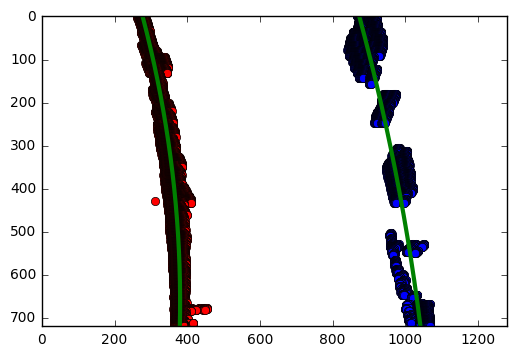

In [321]:
# Plot up the fake data
polynome_data = fit_as_polynome(filtered_points)
plt.plot(polynome_data[0][3], polynome_data[0][2], 'o', color='red')
plt.plot(polynome_data[1][3], polynome_data[1][2], 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(polynome_data[0][0], polynome_data[0][1], color='green', linewidth=3)
plt.plot(polynome_data[1][0], polynome_data[1][1], color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

## Measuring Curvature and Offset

The code bellow measures the curvature of the lane-line both in pixals and in real world. The parameter I choosed is:

* y: 25/720 meters/pixal
* x: 3.7/700 meters/pixal

In [322]:
def get_polynome_result(polynome_data):
    y_eval = np.max(polynome_data[0][1])
    left_curverad = ((1 + (2*polynome_data[0][4][0]*y_eval + polynome_data[0][4][1])**2)**1.5) \
                                 /np.absolute(2*polynome_data[0][4][0])

    y_eval = np.max(polynome_data[1][1])
    right_curverad = ((1 + (2*polynome_data[1][4][0]*y_eval + polynome_data[1][4][1])**2)**1.5) \
                                    /np.absolute(2*polynome_data[1][4][0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(polynome_data[0][2]*ym_per_pix, polynome_data[0][3]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(polynome_data[1][2]*ym_per_pix, polynome_data[1][3]*xm_per_pix, 2)
    
#     print(polynome_data[0][4])
#     print(polynome_data[1][4])
    
#     print(left_fit_cr)
#     print(right_fit_cr)
    
    y_eval = np.max(polynome_data[0][1]) * ym_per_pix
    left_curverad_world = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad_world = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
        
#     print(left_curverad_world)
#     print(right_curverad_world)
    # Now our radius of curvature is in meters
    offset = ((polynome_data[0][4][0]*720**2 + polynome_data[0][4][1]*720 + polynome_data[0][4][2]) + (polynome_data[1][4][0]*720**2 + polynome_data[1][4][1]*720 + polynome_data[1][4][2])) / 2 - (1280/2) 
    
    offset_world = offset * xm_per_pix
    
    return (left_curverad,right_curverad,left_curverad_world,right_curverad_world,offset,offset_world)

In [323]:
polynome_result = get_polynome_result(polynome_data)
print(polynome_result[0], polynome_result[1])
print(polynome_result[2], 'm', polynome_result[3], 'm')
print(polynome_result[4], polynome_result[5], 'm')

2124.56763045 4344.26708937
484.081941158 m 959.73925503 m
70.7923342482 0.374188052455 m


## Merge back to original image 

In [269]:
def merge_inv_back_to_img(image, warped_img, data, inverse_m):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([data[0][0], data[0][1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([data[1][0], data[1][1]])))])
    pts = np.hstack((pts_left, pts_right))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_m, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
    

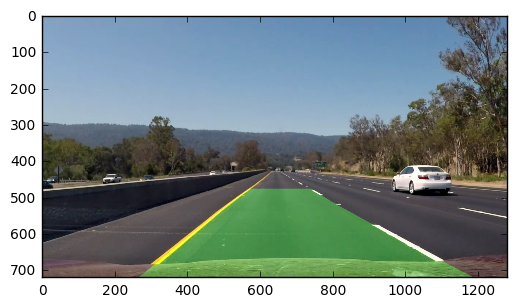

In [270]:
Minv = get_m_transform()[1]
result_img = merge_inv_back_to_img(imageTest, warped, polynome_data, Minv)
plt.imshow(result_img)

# Final Code

I filtered the result by average recent 10 result of iterations, and dropout ones that looks like invalid.

If the curvature of left and right lane lines looks like:

1. Similar curvature
2. Separated by approximately the right distance horizontally
3. Roughly parallel

by comparing their polynomial parameters, I'll decide it as a valid result.
The radius of the curvation is the average result of the left and right lane-lines

In [271]:
n_iters = 10

In [272]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # polynomial coefficients of lastn iterations
        self.recent_fit = [[np.array([False])]]
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update_line(self):
        self.recent_xfitted.append(self.allx)
        self.recent_fit.append(self.current_fit)
        
        if len(self.recent_xfitted) > n_iters:
            self.recent_xfitted.remove(self.recent_xfitted[0])
            
        if len(self.recent_fit) > n_iters:
            self.recent_fit.remove(self.recent_fit[0])
            
        self.bestx = sum(self.recent_xfitted)/n_iters
#         self.best_fit = sum(self.recent_fit)/n_iters
        
#         print(self.allx.shape)
#         print(self.bestx.shape)
        
            
        
        

In [273]:
left_line = Line()
right_line = Line()


In [274]:
def is_valid_line(l_line, r_line):
    dif_c1 = abs(l_line.current_fit[0] - r_line.current_fit[0])
    dif_c2 = abs(l_line.current_fit[1] - r_line.current_fit[1])
    dif_c3 = abs(l_line.current_fit[2] - r_line.current_fit[2])
    if (dif_c1 < 0.001) & (dif_c2 < 0.5) & (dif_c3 < 900) & (dif_c3 > 500):
        return True
    else:
        return False
    

In [335]:
def process_image(image):
    threshould_img = get_threshold_image(image)
    warped_img = undistort_img(threshould_img)
    
    window_width = 100 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    filtered_result = get_filtered_points(warped_img, window_width, window_height, margin)
    
    data = fit_as_polynome(filtered_result)
    
    p_result = get_polynome_result(data)
    
    result_s = "Radius is %.1f m, and %f m left of the center"% ((p_result[2]+p_result[3])/2,p_result[5])
#     print(result_s)
    
    left_line.current_fit = data[0][4]
    left_line.allx = data[0][0]
    left_line.ally = data[0][1]
    
    right_line.current_fit = data[1][4]
    right_line.allx = data[1][0]
    right_line.ally = data[1][1]
    
    if is_valid_line(left_line, right_line):
        left_line.update_line()
        right_line.update_line()
        
    Minv = get_m_transform()[1]

    if len(left_line.recent_xfitted) < n_iters:
        format_data = ((left_line.allx,left_line.ally),(right_line.allx,right_line.ally))
    else:   
        format_data = ((left_line.bestx,left_line.ally),(right_line.bestx,right_line.ally))
    
    result_img = merge_inv_back_to_img(image, warped_img, format_data, Minv)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result_img,result_s,(100,100), font, 1,(255,255,255),2)
    return result_img

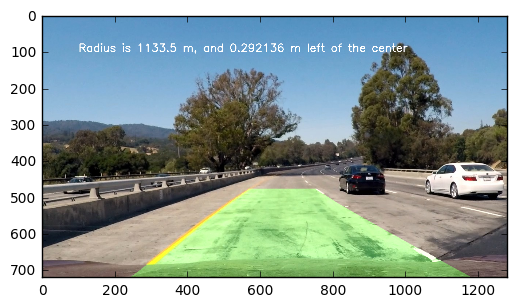

In [336]:
left_line = Line()
right_line = Line()
imageTest = mpimg.imread('test_images/test1.jpg')
imageResult = process_image(imageTest)
plt.imshow(imageResult)

In [337]:
from moviepy.editor import VideoFileClip

output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



100%|█████████▉| 1260/1261 [22:36<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 22min 31s, sys: 1min 20s, total: 23min 52s
Wall time: 22min 37s


## Old codes

Those codes bellow are the ones that I use to filter the lane-line pixals, it's based on histogram instead of the convolution method

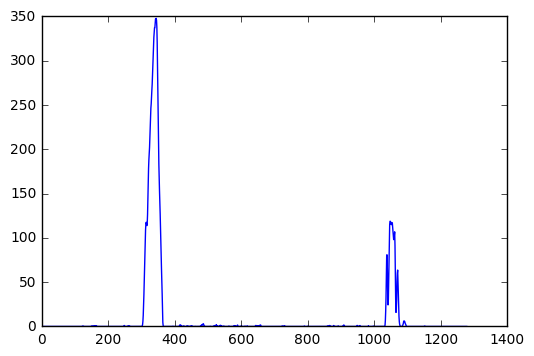

In [353]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

349
341
333
329
326
323
324
323


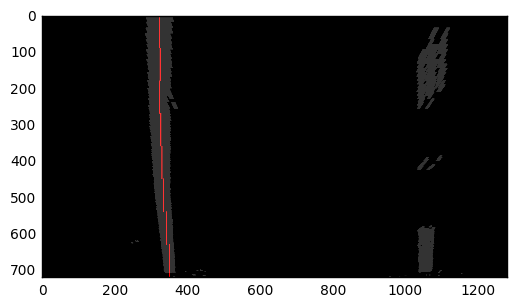

In [358]:
histogram_left = histogram[0:len(histogram)/2]
histogram_right = histogram[len(histogram)/2:len(histogram)]

idx_l = np.argmax(histogram_left)
idx_r = np.argmax(histogram_right)

warp = np.copy(warped)
warp = np.zeros((*warped.shape, 3), dtype=np.uint8)
lines = np.zeros((*warped.shape, 3), dtype=np.uint8)

curve_points_l_row = []
curve_points_l_column = []
curve_points_r_row = []
curve_points_r_column = []

div = 8
for i in range(0,div):
    j = div - 1 -i
    img_j = warped[warped.shape[0]/div*j : warped.shape[0]/div*(j+1),:]
    img_j_left = img_j[:,0:len(img_j[0])/2]
    img_j_right = img_j[:,len(img_j[0])/2:len(img_j[0])]
    
    hist_data = []
    for k in range(idx_l - 50,idx_l + 50):
        left_window_l = img_j_left[:,k - 100:k]
        left_window_r = img_j_left[:,k:k + 100]
        
        hist_l = np.sum(np.sum(left_window_l[:,:], axis=0), axis =0)
        hist_r = np.sum(np.sum(left_window_r[:,:], axis=0), axis =0)
        
        if ((int)(hist_l) < 10) | ((int)(hist_r) < 10):
            hist_data.append(10000)
        else:
            hist_data.append(abs(hist_l-hist_r))
       
    center_left = np.argmin(hist_data)
    cl_min = np.min(hist_data)
    if cl_min != 10000:
        center_left = center_left + idx_l - 50
        idx_l = center_left
    
#     print(hist_data)
    
    hist_data_r = []
    for l in range(idx_r - 50,idx_r + 50):
        right_window_l = img_j_right[:,l - 100:l]
        right_window_r = img_j_right[:,l:l + 100]
              
        hist_l = np.sum(np.sum(right_window_l[:,:], axis=0), axis =0)
        hist_r = np.sum(np.sum(right_window_r[:,:], axis=0), axis =0)
        
        if ((int)(hist_l) < 10) | ((int)(hist_r) < 10):
            hist_data_r.append(10000)
#             print("abc")
        else:
            hist_data_r.append(abs(hist_l-hist_r))
    
    center_right = np.argmin(hist_data_r)
    cr_min = np.min(hist_data_r)
    if cr_min != 10000:
#     print(center_right)
        center_right = center_right + idx_r - 50
        idx_r = center_right
    
        
    print(idx_l)
    cv2.line(lines, (idx_l, (int)(warped.shape[0]/div*j)), (idx_l, (int)(warped.shape[0]/div*(j+1))), color=[255, 0, 0], thickness=2)
#     print(hist_data_r)
    
    left_img = img_j_left[:,center_left - 100:center_left+100]
    points_l = np.nonzero(left_img)
    points_l_row = points_l[0]
    points_l_column = points_l[1]
    
    points_l_row += (int)(warped.shape[0]/div*j)
    points_l_column += center_left - 100
    
    curve_points_l_row = np.concatenate((curve_points_l_row, points_l_row), axis=0)
    curve_points_l_column = np.concatenate((curve_points_l_column, points_l_column), axis=0)
    
    
    
    right_img = img_j_right[:,center_right - 100:center_right+100]
    points_r = np.nonzero(right_img)
    points_r_row = points_r[0]
    points_r_column = points_r[1]
    
    points_r_row += (int)(warped.shape[0]/div*j)
    points_r_column += center_right - 100 + (int)(len(histogram)/2)
    
    curve_points_r_row = np.concatenate((curve_points_r_row, points_r_row), axis=0)
    curve_points_r_column = np.concatenate((curve_points_r_column, points_r_column), axis=0)
    
#     right_img = img_j_right[:,center_right - 100:center_right+100]
#     points_l = np.transpose(np.nonzero(left_img))
#     curve_points_l.append(points_l)
    
#     cv2.line(warp, (center_left, (int)(warped.shape[0]/6*j)), (center_left, (int)(warped.shape[0]/6*(j+1))), 255, 2)
#     cv2.line(warp, (center_right + (int)(len(histogram)/2), (int)(warped.shape[0]/6*j)), (center_right + (int)(len(histogram)/2), (int)(warped.shape[0]/6*(j+1))), [255,0,0], 2)
    
#     print(center_left)
#     print(center_right)
# print(curve_points_l_row)       
for n in range(0,len(curve_points_l_row)):
    y = (int)(curve_points_l_row[n])
    x = (int)(curve_points_l_column[n])
    cv2.line(warp, (x, y), (x-1, y), color=[255, 255, 255], thickness=2)

for n in range(0,len(curve_points_r_row)):
    y = (int)(curve_points_r_row[n])
    x = (int)(curve_points_r_column[n])
    cv2.line(warp, (x, y), (x-1, y), color=[255, 255, 255], thickness=2)
    
    
result = cv2.addWeighted(warp, 0.2, lines, 1, 0)
    
# print(curve_points_l[0])
plt.imshow(result) 
# plt.plot(hist_l)
    

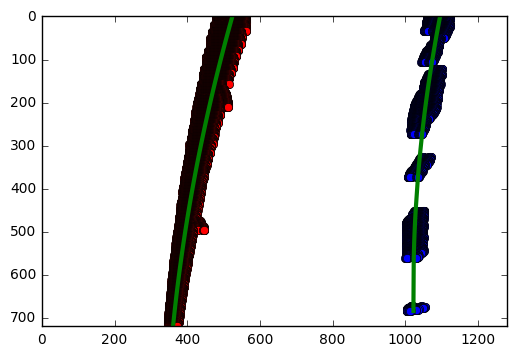

In [280]:
# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(curve_points_l_row, curve_points_l_column, 2)
left_fitx = left_fit[0]*curve_points_l_row**2 + left_fit[1]*curve_points_l_row + left_fit[2]
right_fit = np.polyfit(curve_points_r_row, curve_points_r_column, 2)
right_fitx = right_fit[0]*curve_points_r_row**2 + right_fit[1]*curve_points_r_row + right_fit[2]

# Plot up the fake data
plt.plot(curve_points_l_column, curve_points_l_row, 'o', color='red')
plt.plot(curve_points_r_column, curve_points_r_row, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, curve_points_l_row, color='green', linewidth=3)
plt.plot(right_fitx, curve_points_r_row, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [221]:
y_eval = np.max(curve_points_l_row)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])

y_eval = np.max(curve_points_r_row)
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2679.99238647 2168.81126161


In [222]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/650 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(curve_points_l_row*ym_per_pix, curve_points_l_column*xm_per_pix, 2)
right_fit_cr = np.polyfit(curve_points_r_row*ym_per_pix, curve_points_r_column*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1797.17553065 m 2014.94508477 m


In [226]:
# left_fitx = curve_points_l_row
ploty1 = curve_points_l_row
# right_fitx = curve_points_r_row
ploty2 = curve_points_r_row

[ 526.90061959  526.90061959  526.90061959 ...,  350.55295431  350.55295431
  350.55295431]


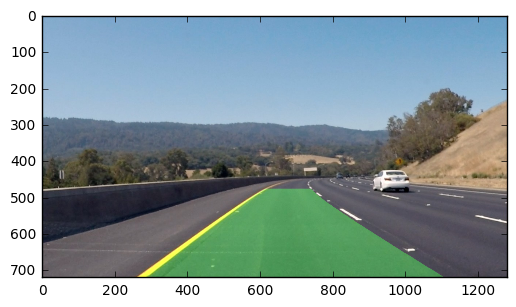

In [227]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty1]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty2])))])
pts = np.hstack((pts_left, pts_right))


# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
print(left_fitx)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (imageTest.shape[1], imageTest.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(imageTest, 1, newwarp, 0.3, 0)
plt.imshow(result)


## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.